In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))
mis_runs = load_runs('../../../sacred_data/sacred_runs_mis/')
print("Loaded mis runs:", len(mis_runs.keys()))

Loaded runs: 572
Loaded final runs: 704
Loaded mis runs: 85


In [86]:
mis_runs_local = load_runs('../sacred_mis/')
print("Loaded mis runs:", len(mis_runs_local.keys()))
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))

Loaded mis runs: 430
Loaded pdisnn runs: 453


In [87]:
# Merge the runs
total_runs = {}
for key, value in mis_runs.items():
    total_runs[str(key) + '-mis'] = value
for key, value in mis_runs_local.items():
    total_runs[str(key) + '-mis-local'] = value
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-pdislocal'] = value

In [88]:
base_query = {
    #'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## Cartpole - Increasing capacity

Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20


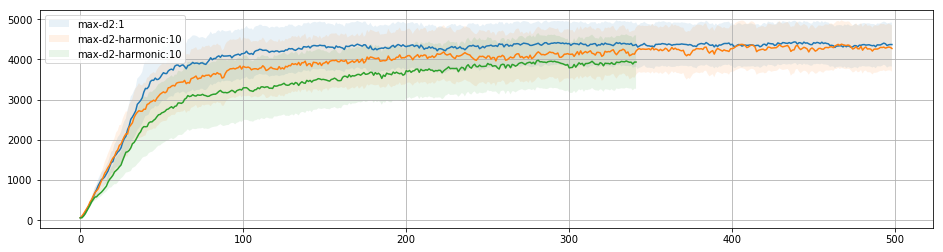

Seeds: 100, 481, 315, 712, 307, 545, 15, 963, 662, 746, 947, 689, 42, 245, 153, 950, 236, 8, 178, 247


In [89]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
for j, (njobs, warm_start, bound, capacity, i) in enumerate([(1, None, 'max-d2', None, 'zeros'),
                                                        (10, True, 'max-d2-harmonic', 1, 'zeros'),
                                                        (10, True, 'max-d2-harmonic', 2, 'zeros'),
                                                       ]):
    
    query = {
            'config.env': 'rllab.cartpole',
            'config.iw_method': 'is',
            'config.delta': 0.4,
            'config.bound': bound,
            'config.num_episodes': 100,
            'config.policy_init': 'zeros',
            'config.max_offline_iters': 10,
            'config.njobs': njobs,
            'config.warm_start': warm_start,
            'config.capacity': capacity
        }
    # Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
    SEED = 178
    if j == 0:
        pass
        #query['config.seed'] = SEED
    if j == 1:
        query['config.experiment_name'] = 'pomis2_cartpole_tenjob'
        #query['config.seed'] = SEED
    if j == 2:
        query['config.experiment_name'] = 'pomis2_cartpole_final'
        #query['config.seed'] = SEED
        
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    if j == 1:
        filtered_runs = {key: value for key, value in filtered_runs.items() if value['config']['seed'] < 1000}
    print("Seeds:", ", ".join(map(str, sorted([filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()]))))
    print(len([filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()]))
    if j == 14:
        plot_all(filtered_runs, 'EpRewMean', axis)
        print(list(filtered_runs.items())[0][1]['config'])
    elif len(filtered_runs.keys()) > 0:
        plot_mean_ci(filtered_runs, 'EpRewMean', axis, label=bound+':'+str(njobs), alpha=0.1)
plt.legend()
plt.grid(True)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

### Cartpole
First we start by validating the equivalence with just one policy

In [ ]:
N = 2
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,N*3), sharex=True, sharey=True)
for i, (method, bound, delta, ws) in enumerate([('is', 'max-d2', 0.4, None), 
                                              ('is', 'max-d2-harmonic', 0.4, True),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 1,
        'config.seed': 662,
        'config.warm_start': ws
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
fig, axis = plt.subplots(nrows=6, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 20,
        'config.capacity': 5
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i], legend=False)
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
for (capacity, episodes, bound, moi, i) in [(None, 100, 'max-d2', 10, 'zeros'),
                                         #(1, 20, 'max-d2', 10),
                                         (10, 100, 'max-d2-harmonic', 10, 'zeros'),
                                         (10, 100, 'max-d2-harmonic', 10, 'xavier')]:
    
    query = {
            'config.env': 'rllab.cartpole',
            'config.iw_method': 'is',
            'config.delta': 0.4,
            'config.bound': bound,
            'config.num_episodes': episodes,
            'config.policy_init': i,
            'config.capacity': capacity,
            'config.max_offline_iters': moi,
        }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print(len(filtered_runs.keys()))
    if len(filtered_runs.keys()) > 0:
        plot_mean_ci(filtered_runs, 'EpRewMean', axis, label=bound+':'+str(i))
plt.legend()
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Inverted double pendulum

In [ ]:
fig, axis = plt.subplots(nrows=9, ncols=1, figsize=(16,24), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.6),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.8),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-double-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-double-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 20,
        'config.capacity': 5
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
for (capacity, episodes, bound, delta) in [(None, 100, 'max-d2', 0.1),
                                    (10, 100, 'max-d2-harmonic', 0.3),
                                    #(5, 20, 'max-d2-harmonic', 0.7)
                                          ]:
    
    query = {
            'config.env': 'rllab.inverted-double-pendulum',
            'config.iw_method': 'is',
            'config.delta': delta,
            'config.bound': bound,
            'config.num_episodes': episodes,
            'config.policy_init': 'zeros',
            'config.capacity': capacity,
        }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    if len(filtered_runs.keys()) > 0:
        plot_mean_ci(filtered_runs, 'EpRewMean', axis)

plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Inverted pendulum

In [ ]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.3), 
                                              ('is', 'max-d2-harmonic', 0.6),
                                              ('is', 'max-d2-harmonic', 0.9),
                                              ('is', 'max-d2-harmonic', 0.99),
                                              ('is', 'max-d2-harmonic', 0.9999),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, mis_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9999,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
query_is = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
}
filtered_runs_is = filter_runs({**base_query, **query_is}, total_runs)
plot_mean_ci(filtered_runs_is, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Acrobot

In [ ]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.5),
                                              ('is', 'max-d2-harmonic', 0.7),
                                              ('is', 'max-d2-harmonic', 0.9),
                                            ]):
    query = {
        'config.env': 'rllab.acrobot',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
query = {
        'config.env': 'rllab.acrobot',
        'config.iw_method': 'is',
        'config.delta': 0.5,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
query_is = {
        'config.env': 'rllab.acrobot',
        'config.iw_method': 'is',
        'config.delta': 0.7,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
}
filtered_runs_is = filter_runs({**base_query, **query_is}, total_runs)
plot_mean_ci(filtered_runs_is, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Mountain car

In [ ]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.6), 
                                              ('is', 'max-d2-harmonic', 0.8),
                                              ('is', 'max-d2-harmonic', 0.9),
                                              ('is', 'max-d2-harmonic', 0.99),
                                              ('is', 'max-d2-harmonic', 1.0),
                                            ]):
    query = {
        'config.env': 'rllab.mountain-car',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
query = {
        'config.env': 'rllab.mountain-car',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.capacity': 10
    }
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
query_is = {
        'config.env': 'rllab.mountain-car',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
}
filtered_runs_is = filter_runs({**base_query, **query_is}, total_runs)
plot_mean_ci(filtered_runs_is, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))